## Import required packages

In [109]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset, load_dataset_builder, get_dataset_split_names
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

## Login to Huggingface Hub 
To push the trained model to your Hugging Face Hub

In [103]:
from huggingface_hub import notebook_login
notebook_login()

## Get device

In [104]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)

device:  cuda


## Load and Explore dataset

In [105]:
dataset_name = "tanquangduong/spam-detection-dataset-splits"
dataset = load_dataset(dataset_name)
num_labels = 2
labels = dataset["train"].features["label"].names

Generating train split:   0%|          | 0/8175 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1362 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1363 [00:00<?, ? examples/s]

In [106]:
ds_builder = load_dataset_builder(dataset_name)

In [107]:
# Inspect dataset description
ds_builder.info.description

''

In [108]:
# Inspect dataset features
ds_builder.info.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['not_spam', 'spam'], id=None)}

In [110]:
# show split subsets
get_dataset_split_names(dataset_name)

['train', 'validation', 'test']

In [111]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8175
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1362
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1363
    })
})

In [112]:
dataset["train"].features["label"]

ClassLabel(names=['not_spam', 'spam'], id=None)

In [113]:
dataset['train'][100]

{'text': 'Looking for dataset illustrating the changes in cannabis potency over the past two decades or so, any ideas on where to find up-to-date info on this?',
 'label': 0}

In [114]:
dataset['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 8175
})

In [115]:
dataset['train'].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['not_spam', 'spam'], id=None)}

In [116]:
dataset['train'].features['label']

ClassLabel(names=['not_spam', 'spam'], id=None)

In [117]:
dataset['train'].features['text']

Value(dtype='string', id=None)

In [118]:
type(dataset['train'].features)

datasets.features.features.Features

In [119]:
dataset['train'][0]['label']

0

In [120]:
dataset['train']['label']

[0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,


In [121]:
dataset['train'][0]['text']

'hey I am looking for Xray baggage datasets can you provide me with the same '

### Transform dataset to dataframe

In [123]:
dataset.set_format(type="pandas")
df = dataset["train"][:]
df.head()

,text,label
0,hey I am looking for Xray baggage datasets can...,0
1,"""Get rich quick! Make millions in just days wi...",1
2,URGENT MESSAGE: YOU WON'T BELIEVE WHAT WE HAVE...,1
3,[Google AI Blog: Contributing Data to Deepfake...,0
4,Trying to see if anyone already has timestamps...,0


### Convert label

In [124]:
def label_int2str(row):
    return dataset["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,hey I am looking for Xray baggage datasets can...,0,not_spam
1,"""Get rich quick! Make millions in just days wi...",1,spam
2,URGENT MESSAGE: YOU WON'T BELIEVE WHAT WE HAVE...,1,spam
3,[Google AI Blog: Contributing Data to Deepfake...,0,not_spam
4,Trying to see if anyone already has timestamps...,0,not_spam


### EDA: Label distribution

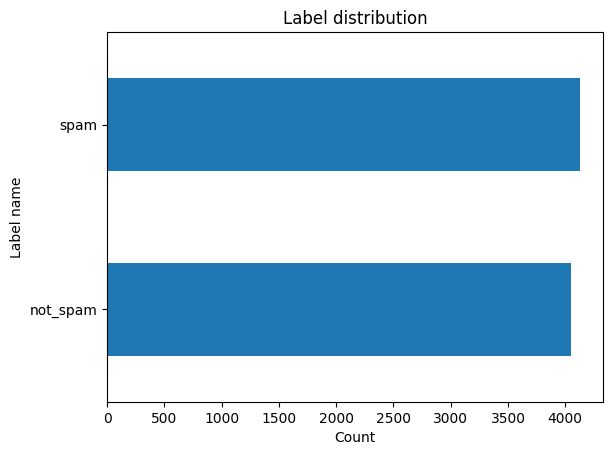

In [125]:
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Label distribution")
plt.ylabel("Label name")
plt.xlabel("Count")
plt.show()

### EDA: Sweet length per label

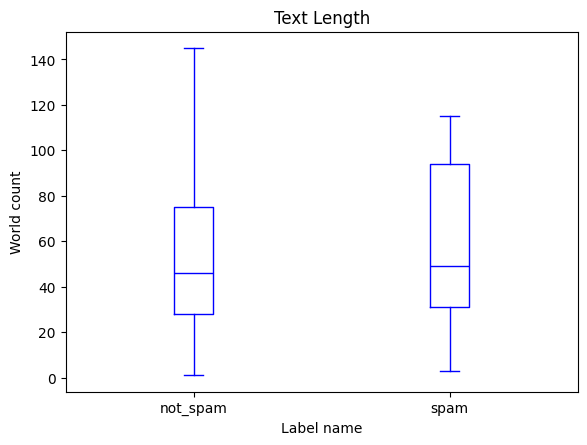

In [128]:
df["Text Length"] = df["text"].str.split().apply(len)
df.boxplot("Text Length", by="label_name", grid=False, showfliers=False,
           color="blue")
plt.suptitle("")
plt.xlabel("Label name")
plt.ylabel("World count")
plt.show()

### Reset dataset format

In [129]:
dataset.reset_format()

## Load tokenizer, model

In [130]:
pretrained_model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name,
    num_labels=num_labels,
).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Tokenize - Encoding text to numerical representation

In [131]:
# tokenizing text batch
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)
    
encoded_dataset = dataset.map(tokenize, batched=True, batch_size=None)
encoded_dataset.set_format(
    "torch", columns=["input_ids", "attention_mask", "label"]
)

Map:   0%|          | 0/8175 [00:00<?, ? examples/s]

Map:   0%|          | 0/1362 [00:00<?, ? examples/s]

Map:   0%|          | 0/1363 [00:00<?, ? examples/s]

## Train functions

In [134]:
config = {
    "BATCH_SIZE": 64,
    "NUM_TRAIN_EPOCHS": 2,
    "LEARNING_RATE": 2e-5,
    "WEIGHT_DECAY": 0.01,
    "DISABLE_TQDM": False,
    "PUSH_TO_HUB": False,
    "EVALUATION_STRATEGY": "epoch",
    "LOG_LEVEL": "error",
    "OUTPUT_DIR": "./models"
}

# Compute metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

# Train
def train(config, encoded_dataset):
    logging_steps = len(encoded_dataset["train"]) // config["BATCH_SIZE"]
    DATASET_NAME = dataset_name.split('/')[-1]
    model_name = f"{pretrained_model_name}-finetuned-{DATASET_NAME}"
    output_dir = os.path.join(config["OUTPUT_DIR"], model_name) 
    
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=config["NUM_TRAIN_EPOCHS"],
        learning_rate=config["LEARNING_RATE"],
        per_device_train_batch_size=config["BATCH_SIZE"],
        per_device_eval_batch_size=config["BATCH_SIZE"],
        weight_decay=config["WEIGHT_DECAY"],
        evaluation_strategy=config["EVALUATION_STRATEGY"],
        disable_tqdm=config["DISABLE_TQDM"],
        logging_steps=logging_steps,
        push_to_hub=config["PUSH_TO_HUB"],
        log_level=config["LOG_LEVEL"],
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=encoded_dataset["train"],
        eval_dataset=encoded_dataset["validation"],
        tokenizer=tokenizer,
    )
    
    trainer.train()
    
    return trainer

# Training

In [135]:
trainer = train(config, encoded_dataset)

C:\Users\easyb\Anaconda3\envs\transformer\lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.087500,0.021046,0.997063,0.997063
2,0.005600,0.020727,0.996329,0.996329


## Inference

In [136]:
preds_output = trainer.predict(encoded_dataset["test"])
y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(encoded_dataset["test"]["label"])    

In [137]:
preds_output.predictions

array([[ 3.155664 , -3.173911 ],
       [-3.3450313,  2.9393322],
       [ 3.1607218, -3.1911335],
       ...,
       [-3.247521 ,  2.8093514],
       [ 3.1830273, -3.188035 ],
       [-3.2609296,  2.8619251]], dtype=float32)

In [138]:
y_preds

array([0, 1, 0, ..., 1, 0, 1], dtype=int64)

## Evaluation

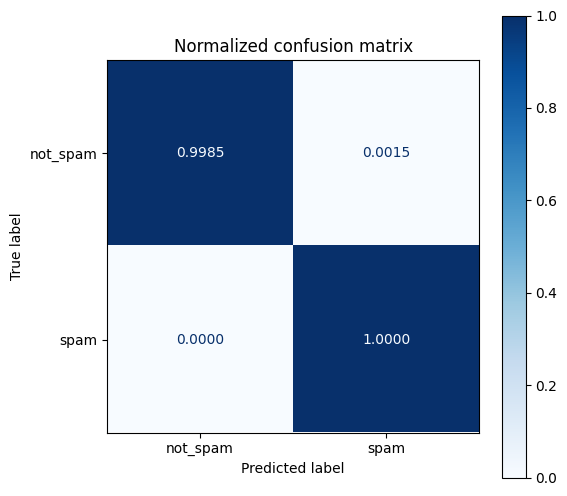

In [146]:
DATASET_NAME = dataset_name.split('/')[-1]
model_name = f"{pretrained_model_name}-finetuned-{DATASET_NAME}"
# plot confusion matrix
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".4f", ax=ax, colorbar=True)
    plt.title("Normalized confusion matrix")
    return fig

fig = plot_confusion_matrix(y_preds, y_valid, labels)
fig.savefig(f'output/{model_name}.png')

In [141]:
cm = confusion_matrix(y_valid, y_preds, normalize="true")
cm

array([[0.99850746, 0.00149254],
       [0.        , 1.        ]])

## Push model to hub

In [143]:
model_name

'distilbert-base-uncased-finetuned-spam-detection-dataset-splits'

In [144]:
trainer.push_to_hub(f"tanquangduong/{model_name}")

events.out.tfevents.1717418056.DESKTOP-FR2HOOJ.9680.0:   0%|          | 0.00/6.37k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/tanquangduong/distilbert-base-uncased-finetuned-spam-detection-dataset-splits/commit/7832f94ac57bf249290f0bd65444ed765f9dc8b5', commit_message='tanquangduong/distilbert-base-uncased-finetuned-spam-detection-dataset-splits', commit_description='', oid='7832f94ac57bf249290f0bd65444ed765f9dc8b5', pr_url=None, pr_revision=None, pr_num=None)